Must be run using jupyter notebook or jupyter lab, for the widgets to work.

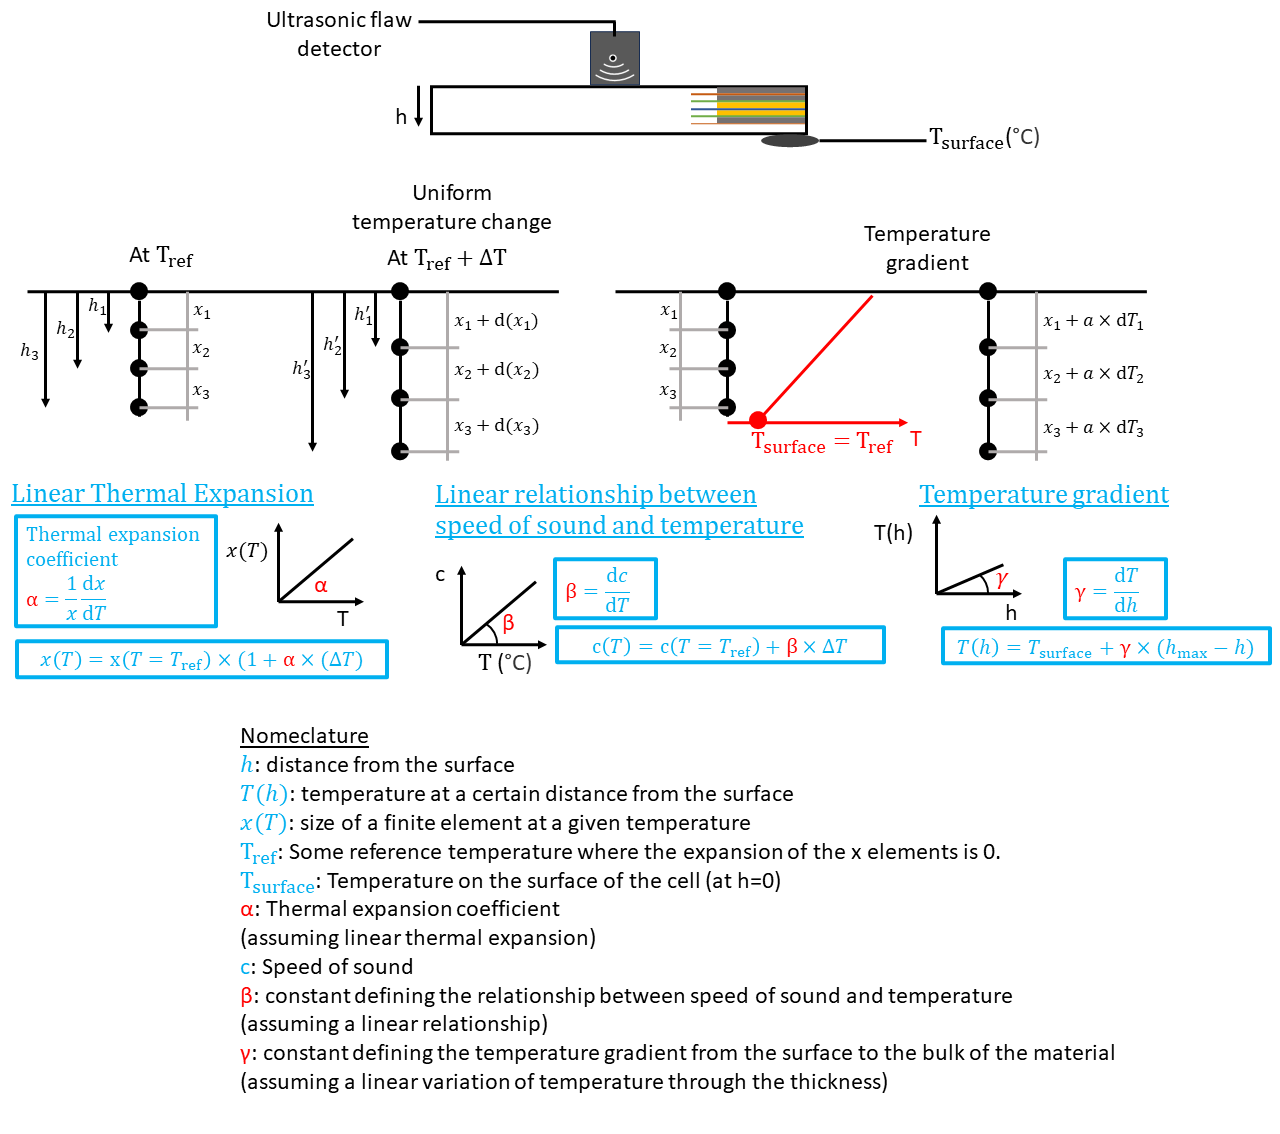

In [4]:
from IPython.display import Image
image = Image('temp_modelling_method.png')
display(image)

In [2]:
%matplotlib ipympl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
#Import interact from ipywidgets
from ipywidgets import interact

In [3]:
plt.close('all')
f, axs = plt.subplots(2, 3, figsize=(9,5), constrained_layout=True, sharex=True)
f.patch.set_facecolor('white')
colorbar_axes = f.colorbar(None, ax=axs, location='left', aspect=45,
           label='Cell coordinate\nh (mm) at $\mathrm{T_{ref}}$')
from matplotlib.pyplot import cm
def plot_tof_vs_temp(alpha, beta, gamma):
    c_ref = 1400 # m/s
    T_ref = 25
    h_max = 5

    # Vectors
    h_ref = np.linspace(0, h_max, 101) # mm
    x_ref = np.full((100,), h_max/100)
    T_surface = np.linspace(11, 32, 100) # degC
    gamma_vector = gamma*T_surface
                    
    # Grids. rows: T_surface. cols: h_ref
    T_surface_grid = np.tile(T_surface[:, np.newaxis], (1, len(h_ref)))
    gamma_grid = np.tile(gamma_vector[:, np.newaxis], (1, len(h_ref)))
    h_grid = np.tile(h_ref, (len(T_surface), 1))
    x_grid = np.tile(x_ref, (len(T_surface), 1))
    
    # Computations
    T_h = T_surface_grid + gamma_grid*(h_max-h_grid) # Temperature at different thicknesses
    T_x = 0.5*(T_h[:,0:-1] + T_h[:,1:]) # Temperature of elemental lentghs
    x_grid_expanded = x_grid + alpha * x_grid * (T_x-T_ref) # Elemental thermal expansion
    h_grid_expanded = np.concatenate(
        (h_grid[:,0][:, np.newaxis], np.cumsum(x_grid_expanded, axis = 1)), axis=1) # cumulative thermal expansion
    c_grid = c_ref + beta * (T_h-T_ref)
    tof = (h_grid_expanded / 1000) / c_grid *1E6 # microseconds
    delta_tof = (tof - tof[0,:]) * 1000 # nanoseconds
    delta_tof_pct = (tof[:,1:] - tof[0,1:]) / tof[:,1:] * 100 # Avoid division by 0
    
    # ------------------------------------
    # Plot
    axs[0,0].clear()
    axs[0,1].clear()
    axs[0,2].clear()
    axs[1,0].clear()
    axs[1,1].clear()
    axs[1,2].clear()
    
    # Surface temperature vs bulk temperature
    cmesh00 = axs[0,0].pcolormesh(T_surface_grid, T_h, h_grid, cmap=cm.Greens, shading='gouraud')
    contours00 = axs[0,0].contour(T_surface_grid, T_h, h_grid, levels = 6, colors = 'k', 
                           linewidths=1, linestyles='dashed')    
    
    # Surface temperature vs c
    cmesh01 = axs[0,1].pcolormesh(T_surface_grid, c_grid, h_grid, cmap=cm.Greens, shading='gouraud')
    contours01 = axs[0,1].contour(T_surface_grid, c_grid, h_grid, levels = 6, colors = 'k', 
                           linewidths=1, linestyles='dashed')
    
    # Surface temperature vs expanded x
    cmesh02 = axs[0,2].pcolormesh(T_surface_grid, h_grid_expanded, h_grid, cmap=cm.Greens, shading='gouraud')
    contours02 = axs[0,2].contour(T_surface_grid, h_grid_expanded, h_grid, levels = 6, colors = 'k', 
                           linewidths=1, linestyles='dashed')

    # Surface temperature vs Tof
    cmesh10 = axs[1,0].pcolormesh(T_surface_grid, tof, h_grid, cmap=cm.Greens, shading='gouraud')
    contours10 = axs[1,0].contour(T_surface_grid, tof, h_grid, levels = 6, colors = 'k',
                           linewidths=1, linestyles='dashed')
    axs[1,0].clabel(contours10, contours10.levels, inline=True)
    
    # Surface temperature vs ΔToF
    cmesh11 = axs[1,1].pcolormesh(T_surface_grid, delta_tof, h_grid, cmap=cm.Greens, shading='gouraud')
    contours11 = axs[1,1].contour(T_surface_grid, delta_tof, h_grid, levels = 6, colors = 'k', 
                           linewidths=1, linestyles='dashed')
    
    # Surface temperature vs ΔToF (%)
    # Ensuring that division by zero is avoided. --> Dont consider the surface (x=0) where tof wil be 0.
    cmesh12 = axs[1,2].pcolormesh(T_surface_grid[:,1:], delta_tof_pct, h_grid[:,1:], cmap=cm.Greens, shading='gouraud')
    contours12 = axs[1,2].contour(T_surface_grid[:,1:], delta_tof_pct, h_grid[:,1:], levels = 6, colors = 'k', 
                           linewidths=1, linestyles='dashed')      
    
    # Annotate axes and colorbar
    
    axs[0,0].set_ylabel('T ($^\circ$C)')
    axs[0,1].set_ylabel('c (m/s)')
    axs[0,2].set_ylabel('$\mathrm{h_{expanded}}$ (mm)')

    axs[1,0].set_xlabel('$T_{surface}$ ($^\circ$C)')
    axs[1,1].set_xlabel('$T_{surface}$ ($^\circ$C)')
    axs[1,2].set_xlabel('$T_{surface}$ ($^\circ$C)')
    
    axs[1,0].set_ylabel('ToF ($\mathrm{\mu}$s)')
    axs[1,1].set_ylabel('ΔToF (nanoseconds)')
    axs[1,2].set_ylabel('ΔToF (%)')
    axs[1,0].set_ylim(-0.1, 4)
    axs[1,1].set_ylim(-20, 105)
    axs[1,2].set_ylim(-0.5, 5)
    #
    axs[0,1].ticklabel_format(style='plain', useOffset=False)
    
    # f.colorbar(cmesh11, ax=axs, location='left', aspect=45,
    #            label='Cell coordinate\nh (mm) at $\mathrm{T_{ref}}$')
    colorbar_axes.mappable.set_clim(vmin=cmesh11.get_array().min(), vmax=cmesh11.get_array().max())
    colorbar_axes.update_normal(cmesh11)
    
    
    f.suptitle(r'$\alpha$={} $\beta$={}  $\gamma$={}'.format(alpha, beta, gamma))
    plt.show()

#INTERACT
alpha_max = 1.3E-3
beta_max = 2
gamma_max = 0.07
int_plot = interact(plot_tof_vs_temp,
                    alpha = widgets.FloatSlider(description = r'$\alpha$',
                        value=0, min=0, max=alpha_max, step=alpha_max/10, readout_format='.7f'),
                    beta = widgets.FloatSlider(description = r'$\beta$',
                        value=0, min=-beta_max, max=beta_max, step=beta_max/10, readout_format='.7f'),
                    gamma = widgets.FloatSlider(description = r'$\gamma$',
                        value=0, min=-gamma_max, max=gamma_max, step=gamma_max/10, readout_format='.7f'),
                   )   

interactive(children=(FloatSlider(value=0.0, description='$\\alpha$', max=0.0013, readout_format='.7f', step=0…